In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from tensorflow.compat.v1.nn import rnn_cell
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout

In [3]:
datos=pd.read_csv('N225_Limpiado_Actual')
cierre=datos['Close'].values.astype('float32')
datos
cierre

array([10654.79, 10681.83, 10731.45, ..., 40168.07, 40369.44, 39803.09],
      dtype=float32)

<function matplotlib.pyplot.show(close=None, block=None)>

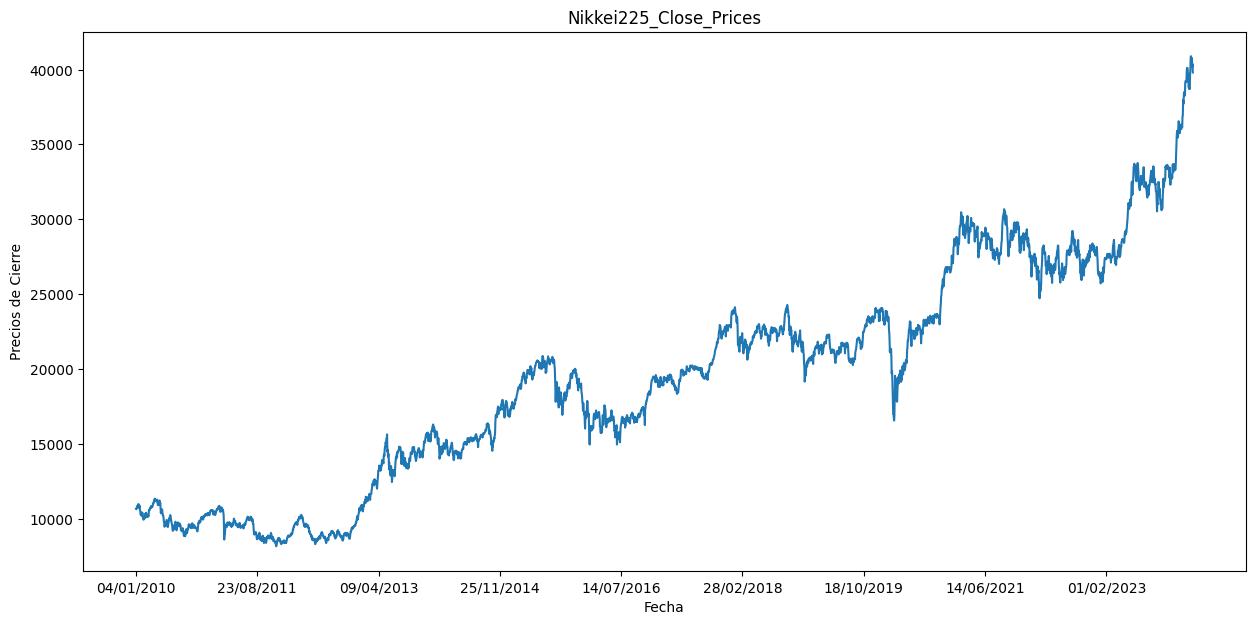

In [4]:
plt.figure(figsize=(15,7))
plt.plot(cierre)
plt.title("Nikkei225_Close_Prices")
plt.xlabel("Fecha")
plt.xticks(range(0,len(datos['Date']),400),datos['Date'][0::400])
plt.ylabel("Precios de Cierre")
plt.show

In [5]:
#Preprocesamiento de los datos

datos_escalados=preprocessing.StandardScaler().fit_transform(cierre.reshape(-1,1)).squeeze()
datos_escalados

array([-1.1997167, -1.1960126, -1.1892155, ...,  2.8430824,  2.8706667,
        2.7930865], dtype=float32)

In [6]:
#Distribución de datos
def data_generator(data, window , distance=0):
    x=[]
    y=[]
    for i in range(len(data)-window-distance):
        x.append(data[i:i+window])
        y.append(data[i+window+distance])
    return np.array(x),np.array(y)

In [7]:
Train_size=int(len(datos_escalados)*0.7)
Test_size=int(len(datos_escalados)*0.2)
Val_size=int(len(datos_escalados)-Train_size-Test_size)

Train_data=datos_escalados[:Train_size]
Test_data=datos_escalados
Val_data=datos_escalados[Train_size:Train_size+Val_size]

Sizeof_block=50

#Generacion de los datos para analisis
train_x,train_y=data_generator(Train_data,Sizeof_block,0)
print(f'\n Datos de entrenamiento: \t Train_x: {train_x.shape} \t Train_y: {train_y.shape}')

test_x,test_y=data_generator(Test_data, Sizeof_block , 0)
print(f'\n Datos de prueba: \t Test_x: {test_x.shape} \t Test_y: {test_y.shape}')

validation_x,validation_y=data_generator(Val_data,Sizeof_block , 0)
print(f'\n Datos de validación: \t Validation_x: {validation_x.shape} \t Validation_y: {validation_y.shape}')


 Datos de entrenamiento: 	 Train_x: (2390, 50) 	 Train_y: (2390,)

 Datos de prueba: 	 Test_x: (3436, 50) 	 Test_y: (3436,)

 Datos de validación: 	 Validation_x: (299, 50) 	 Validation_y: (299,)


#Primer Modelo Propuesto

In [37]:
def redLSTM1(bloque,epocas):

  Sizeblock=bloque

  train_x,train_y=data_generator(Train_data,Sizeblock,0)
  test_x,test_y=data_generator(Test_data,Sizeblock,0)
  val_x,val_y=data_generator(Val_data,Sizeblock,0)

  RNN=tf.keras.Sequential()
  RNN.add(tf.keras.layers.LSTM(
      units=1,
      input_shape=(Sizeblock,1),
      activation='ReLU'
  ))

  RNN.summary()
  RNN.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])
  early_stop = EarlyStopping(monitor = 'val_loss', patience = 10)

  train_x=np.reshape(train_x,(train_x.shape[0], train_x.shape[1],1))
  test_x=np.reshape(test_x,(test_x.shape[0],test_x.shape[1],1))

  history=RNN.fit(train_x, train_y,
                  epochs=epocas,
                  batch_size=int(Sizeblock/2),
                  callbacks=[early_stop],
                  validation_data=(val_x,val_y))

  prediccion=RNN.predict(test_x,verbose=True)

  plt.figure(figsize=(9,5))
  plt.plot(history.history['loss'], '-.',label='Perdida Entrenamiento')
  plt.plot(history.history['val_loss'], '-',label='Perdida Prueba')
  plt.title(f'Modelo de perdida para red LSTM 1')
  plt.xlabel('Época')
  plt.ylabel('Precisión')
  plt.legend()
  plt.show()

  return prediccion

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 1)                 12        
                                                                 
Total params: 12 (48.00 Byte)
Trainable params: 12 (48.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
486/486 [==============================] - 5s 7ms/step - loss: 0.9158 - mean_squared_error: 0.9158 - val_loss: 0.7129 - val_mean_squared_error: 0.7129
Epoch 2/10
486/486 [==============================] - 2s 4ms/step - loss: 0.7015 - mean_squared_error: 0.7015 - val_loss: 0.7129 - val_mean_squared_error: 0.7129
Epoch 3/10
486/486 [==============================] - 4s 9ms/step - loss: 0.7015 - mean_squared_error: 0.7015 - val_loss: 0.7129 - val_mean_squared_error: 0.7129
Epoch 4/10
486/486 [==============================] - 4s 7ms/s

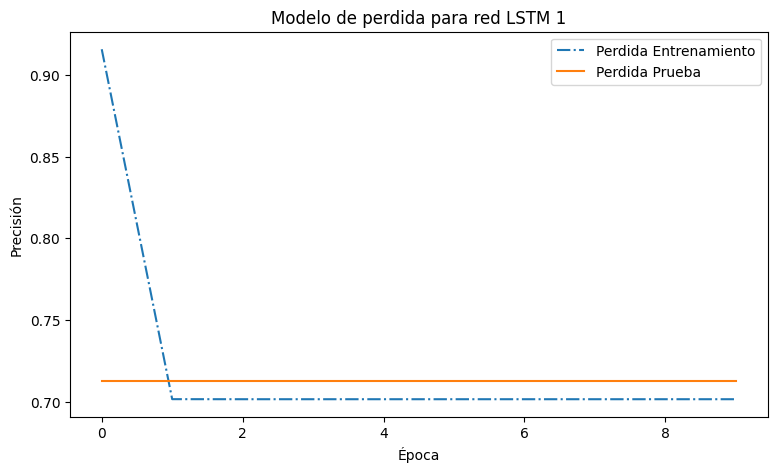

In [30]:
prediccion_m1=redLSTM1(10,10)

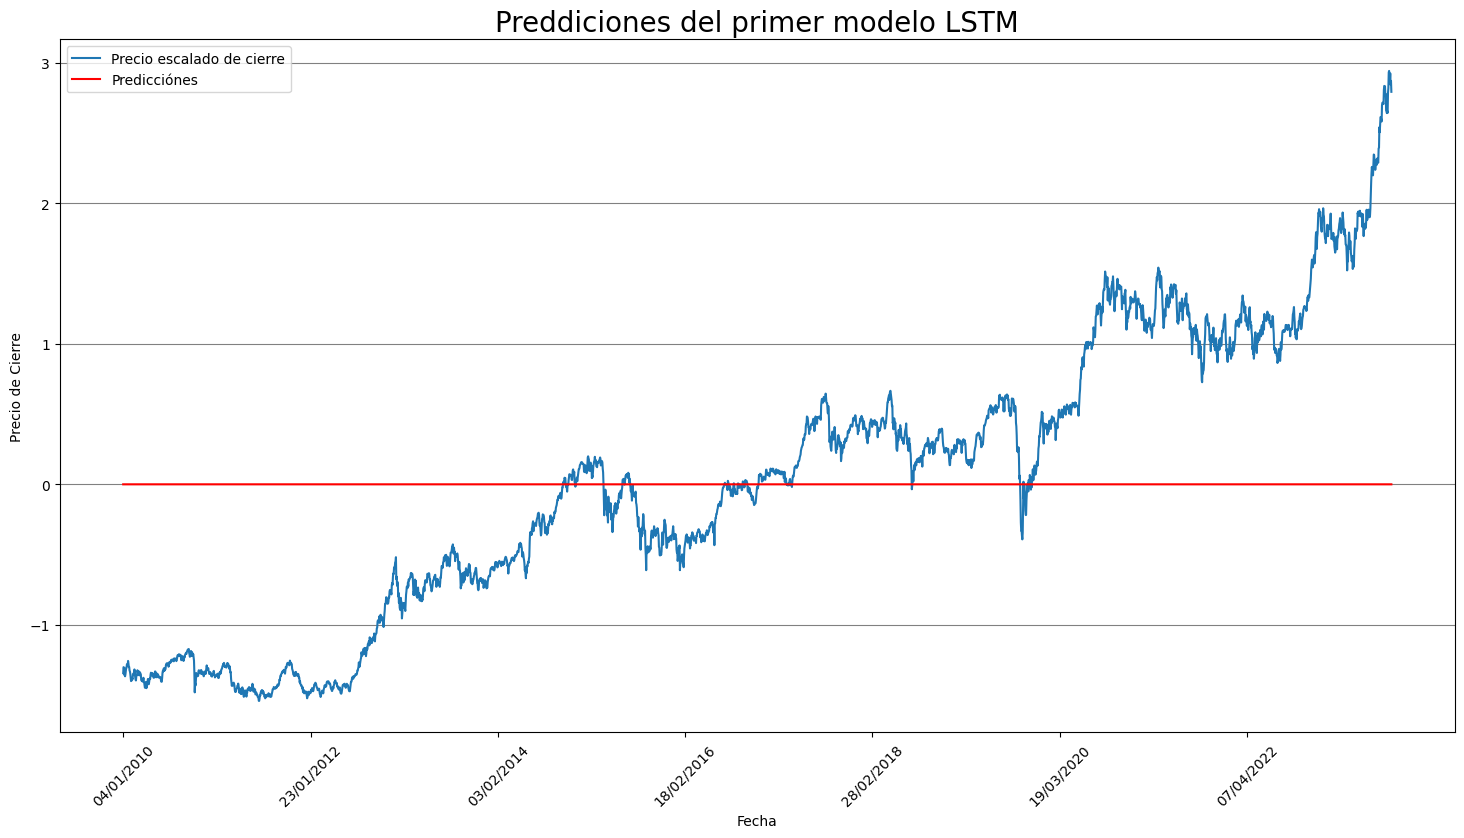

In [32]:
plt.figure(figsize=(18,9))
plt.plot(range(len(datos['Date'][100:])),datos_escalados[100:],label='Precio escalado de cierre')
plt.plot(range(len(datos['Date'][100:])),prediccion_m1[90:], color="red", label='Predicciónes')

plt.xticks(range(0,len(datos['Date']),500),datos['Date'][0::500],rotation=45)
plt.title('Preddiciones del primer modelo LSTM', fontsize=20)
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre')
plt.grid(axis='y',color='gray')
plt.legend()
plt.show()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 1)                 12        
                                                                 
Total params: 12 (48.00 Byte)
Trainable params: 12 (48.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
242/242 [==============================] - 3s 7ms/step - loss: 0.6706 - mean_squared_error: 0.6706 - val_loss: 0.9025 - val_mean_squared_error: 0.9025
Epoch 2/10
242/242 [==============================] - 2s 6ms/step - loss: 0.6682 - mean_squared_error: 0.6682 - val_loss: 0.8424 - val_mean_squared_error: 0.8424
Epoch 3/10
242/242 [==============================] - 1s 6ms/step - loss: 0.6680 - mean_squared_error: 0.6680 - val_loss: 0.5074 - val_mean_squared_error: 0.5074
Epoch 4/10
242/242 [==============================] - 2s 9ms/s

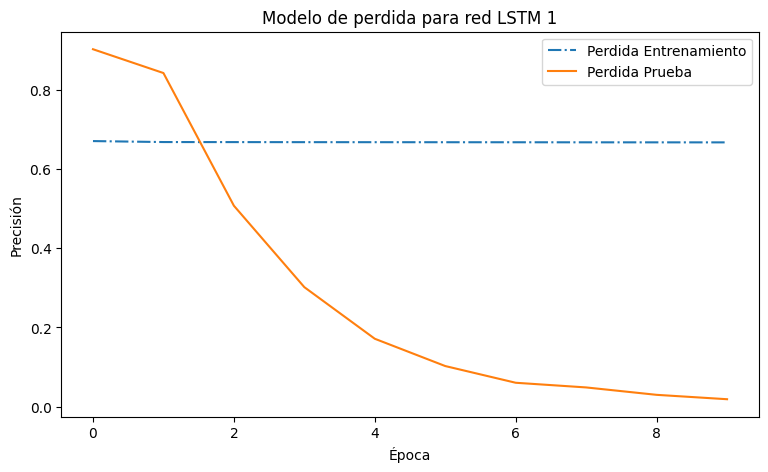

In [33]:
prediccion_m1=redLSTM1(20,10)

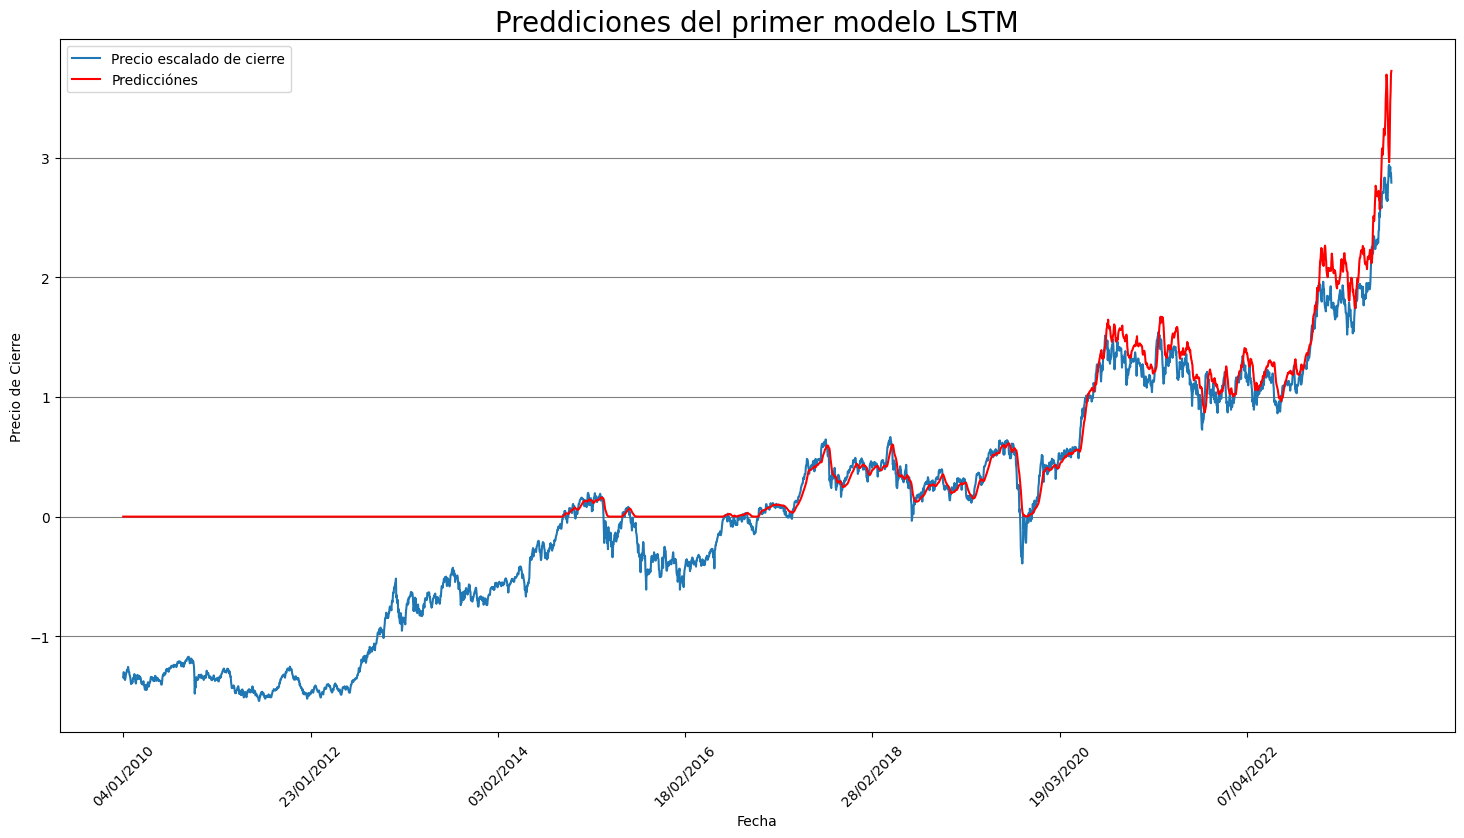

In [34]:
plt.figure(figsize=(18,9))
plt.plot(range(len(datos['Date'][100:])),datos_escalados[100:],label='Precio escalado de cierre')
plt.plot(range(len(datos['Date'][100:])),prediccion_m1[80:], color="red", label='Predicciónes')

plt.xticks(range(0,len(datos['Date']),500),datos['Date'][0::500],rotation=45)
plt.title('Preddiciones del primer modelo LSTM', fontsize=20)
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre')
plt.grid(axis='y',color='gray')
plt.legend()
plt.show()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (None, 1)                 12        
                                                                 
Total params: 12 (48.00 Byte)
Trainable params: 12 (48.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
161/161 [==============================] - 4s 13ms/step - loss: 0.6666 - mean_squared_error: 0.6666 - val_loss: 0.3639 - val_mean_squared_error: 0.3639
Epoch 2/10
161/161 [==============================] - 2s 11ms/step - loss: 0.6637 - mean_squared_error: 0.6637 - val_loss: 0.3017 - val_mean_squared_error: 0.3017
Epoch 3/10
161/161 [==============================] - 2s 11ms/step - loss: 0.6634 - mean_squared_error: 0.6634 - val_loss: 0.2626 - val_mean_squared_error: 0.2626
Epoch 4/10
161/161 [==============================] - 2s 1

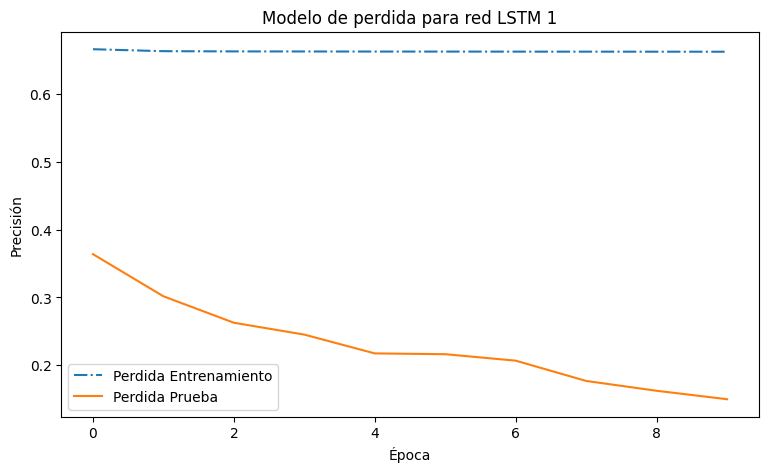

In [38]:
prediccion_m1 = redLSTM1(30,10)

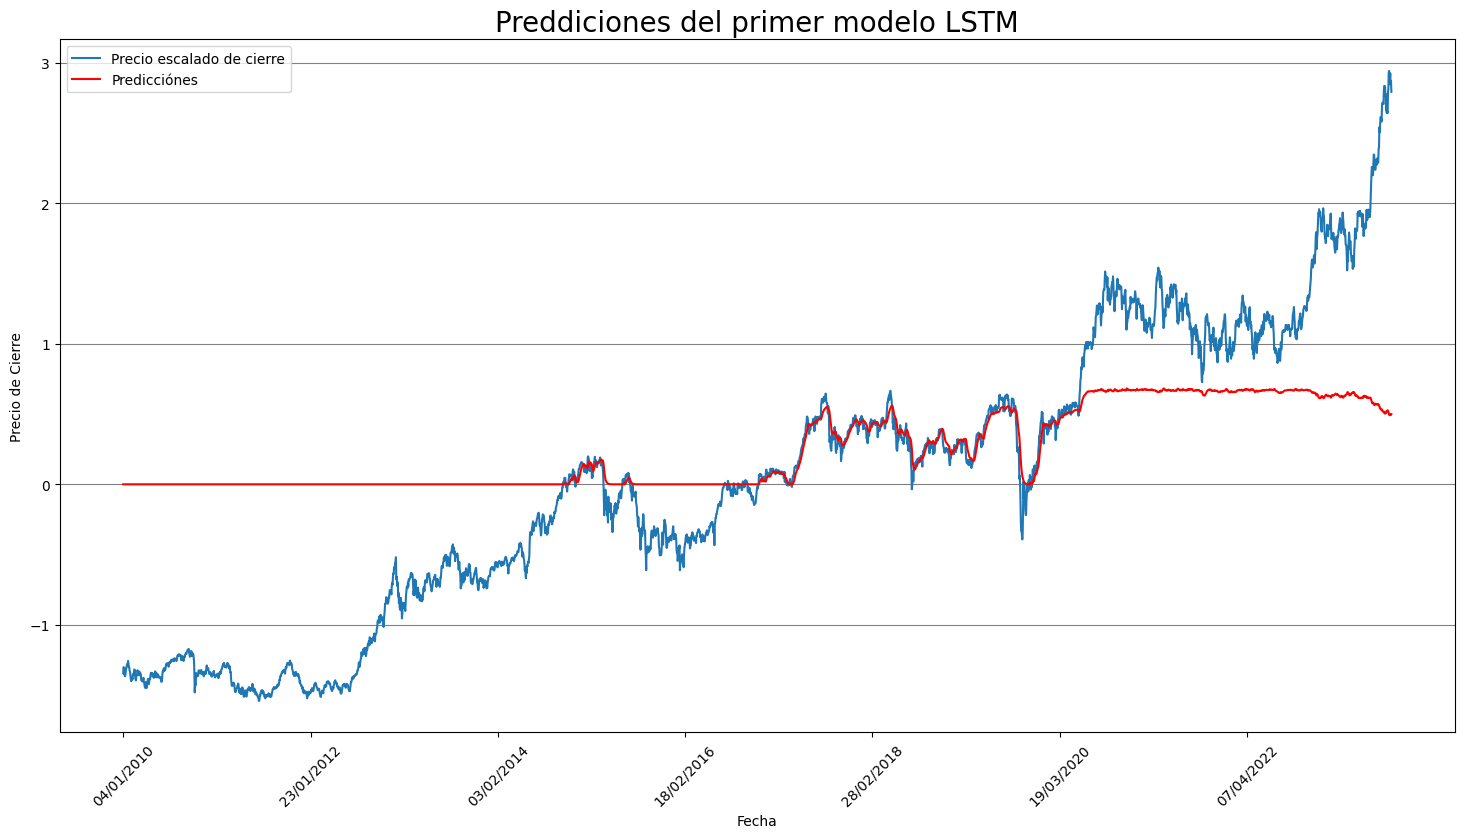

In [39]:
plt.figure(figsize=(18,9))
plt.plot(range(len(datos['Date'][100:])),datos_escalados[100:],label='Precio escalado de cierre')
plt.plot(range(len(datos['Date'][100:])),prediccion_m1[70:], color="red", label='Predicciónes')

plt.xticks(range(0,len(datos['Date']),500),datos['Date'][0::500],rotation=45)
plt.title('Preddiciones del primer modelo LSTM', fontsize=20)
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre')
plt.grid(axis='y',color='gray')
plt.legend()
plt.show()